In [1]:
# All used imports
import numpy as np
import pandas as pd
import pathlib
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.losses import SparseCategoricalCrossentropy

from scipy.signal import stft

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from pathlib import Path
import datetime
import glob as gl


2022-11-22 00:58:11.430269: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Fall detection

#### Our idea is to do event recognition in two steps:


## 1. Logistic Regression

The job of this part is just to tell whether there is anything happening at all.
To train the logistic regressor we have measured various fall events in the laboratory which are used as the positive training samples. 
The negative training samples are extracted from two 24h measurements during which the laboratory was empty.
The measurements come in form of 10 second long snippets.
For every of the snippets we calculate the following five features which are then used to train the logistic regressor.
Before caluclating the features the mean is substracted (zero mean transformation) and the data set is squared.
* maximum
* median
* mean
* 25&75 quantiles


## 2. Classificator
If the first part reports an event, the respective 10 second snippet is transformed into its spectral image using a fast fourier transform.
These images are then fed to a deep neural network which then decides if a person has fallen or if it was something else.

### Implementations

In [2]:
features = ['maximum',
            'median',
            'mean',
            'quantile25',
            'quantile75']
### Implementation of a function that calculates chosen features from a given np.array:

def CalculateFeatures(A: np.array) -> dict:
    #Square all elements in array to calculate the features
    A = np.square(A - np.mean(A))
    
    # 1. Feature 'Maximum'
    Max = np.max(A)
    # 2. Feature 'Median'
    Med = np.median(A)
    # 3. Feature 'Mittelwert'
    Mean = np.mean(A)
    # 4. Feature 'Quantile'
    Q_25 = np.quantile(A, 0.25)
    Q_75 = np.quantile(A, 0.75)
  
    
    return {'maximum': Max,
            'median': Med,
            'mean': Mean,
            'quantile25': Q_25,
            'quantile75': Q_75}

### Implementation of a function that can return a random measurement interval of desired length

def RandomInterval(df: pd.DataFrame, interval_time: int = 10, sampling_rate: int = 1600, return_values: np.array = ['z'], seed: int or None = None) -> np.array:
    if seed:
        np.random.seed(seed)
    # approximate number of points that correspond to interval_time (this is not in accordance with actual time values)
    number_of_points = interval_time / (1 / sampling_rate)
    # last possible beginning of the time interval in order for it to have its full length
    last_possible_start = len(df) - number_of_points
    ## so that number_of_points to be sampled is not hindered when it tries to start from a point after which that many 
    ## no_of_points are not available for sampling
    # Assumption: it does not matter if there are partially overlapping samples -> Randomly draw with no restrictions
    starting_point = np.random.randint(low=0, high=last_possible_start)
    end_point = int(starting_point + number_of_points)
    
    # only return the requested values of the dataframe as np.array 
    return np.array(df[starting_point:end_point][return_values]).reshape(-1)

# 1. Load measured data and derive training data

# Real Events

In [3]:
## example data path
DATA_PATH = Path("/store/projects/fallki/MessdatenFeldversuch/203 S4")

In [4]:
# collect all file in Data Path
runFiles = []
runFiles += DATA_PATH.glob(f'*.bin')
#print(([f.stem for f in runFiles]))

In [5]:
len(runFiles)

169

In [6]:
for x in runFiles:
    #if x == "/store/projects/fallki/MessdatenFeldversuch/206 B5/2022-09-14_18-00-00.bin":
        print(x)

/store/projects/fallki/MessdatenFeldversuch/203 S4/2022-09-11_17-00-00.bin
/store/projects/fallki/MessdatenFeldversuch/203 S4/2022-09-13_14-00-00.bin
/store/projects/fallki/MessdatenFeldversuch/203 S4/2022-09-15_11-00-00.bin
/store/projects/fallki/MessdatenFeldversuch/203 S4/2022-09-09_20-00-00.bin
/store/projects/fallki/MessdatenFeldversuch/203 S4/2022-09-10_16-00-00.bin
/store/projects/fallki/MessdatenFeldversuch/203 S4/2022-09-12_15-00-00.bin
/store/projects/fallki/MessdatenFeldversuch/203 S4/2022-09-14_10-00-00.bin
/store/projects/fallki/MessdatenFeldversuch/203 S4/2022-09-13_15-00-00.bin
/store/projects/fallki/MessdatenFeldversuch/203 S4/2022-09-11_16-00-00.bin
/store/projects/fallki/MessdatenFeldversuch/203 S4/2022-09-15_10-00-00.bin
/store/projects/fallki/MessdatenFeldversuch/203 S4/2022-09-12_14-00-00.bin
/store/projects/fallki/MessdatenFeldversuch/203 S4/2022-09-09_21-00-00.bin
/store/projects/fallki/MessdatenFeldversuch/203 S4/2022-09-10_17-00-00.bin
/store/projects/fallki/Me

In [7]:
# function to load a binary file into a pd.DataFrame

def readBinaryToPandas(filepath, dt=np.dtype('int16'), datetime_fmt=True):
    try:
        df = pd.DataFrame(np.fromfile(filepath, dtype=dt, count=-1, sep=''))
        
    except IOError:
        print("Error while opening the file!")
        
    #We need to reorder data & and add time from filename                   
    x = df.iloc[0::3].to_numpy().reshape(-1)
    y = df.iloc[1::3].to_numpy().reshape(-1)
    z = df.iloc[2::3].to_numpy().reshape(-1)
    
    # I use min_len here, because it appears that sometimes the data is not uploaded entirely
    # In such a case we might have differing numbers of x,y and z values. This way I make sure
    # we are still able to parse every point that has been uploaded completely into a pandas dataframe.
    min_len = np.min([len(x),len(y),len(z)])
    samples_per_second = 1600
    
    print(f"{min_len} rows")
    
    df = pd.DataFrame({'x': x[:min_len],'y': y[:min_len],'z': z[:min_len]})
    df.name = filepath.stem
    
    if datetime_fmt:
        start = datetime.datetime.strptime(filepath.stem,'%Y-%m-%d_%H-%M-%S')
        end = start + datetime.timedelta(seconds=(1 / samples_per_second) * (min_len - 1))
        df['time'] = pd.date_range(start, end, freq="0.625ms")
    else:
        start = 0
        end = (1 / samples_per_second) * (min_len - 1)
        df['time'] = np.linspace(0, end, min_len)
    
    return df


In [8]:
Real_data = readBinaryToPandas(runFiles[59])

5772030 rows


In [9]:
Real_data.insert(loc=0, column='experiment', value= 'real fall')

In [10]:
Real_data

,experiment,x,y,z,time
0,real fall,-1,8,1014,2022-09-13 18:00:00.000000
1,real fall,0,9,1018,2022-09-13 18:00:00.000625
2,real fall,0,9,1016,2022-09-13 18:00:00.001250
3,real fall,-1,6,1016,2022-09-13 18:00:00.001875
4,real fall,-3,5,1018,2022-09-13 18:00:00.002500
...,...,...,...,...,...
5772025,real fall,-3,4,1018,2022-09-13 19:00:07.515625
5772026,real fall,0,4,1020,2022-09-13 19:00:07.516250
5772027,real fall,3,8,1014,2022-09-13 19:00:07.516875
5772028,real fall,-1,10,1010,2022-09-13 19:00:07.517500


Text(0.5, 1.0, 'A single plot')

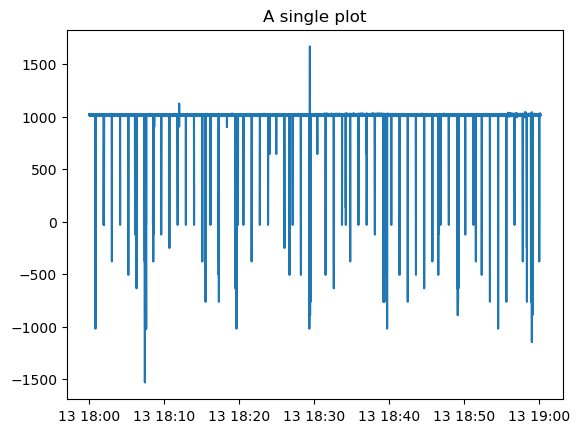

In [11]:
#single plot
fig, ax = plt.subplots()
ax.plot(Real_data['time'],Real_data['z'])
ax.set_title('A single plot')

In [12]:
Real_data[Real_data.z > 1500]

,experiment,x,y,z,time
2822673,real fall,2176,-1024,1667,2022-09-13 18:29:24.170625


Text(0.5, 1.0, 'A single plot')

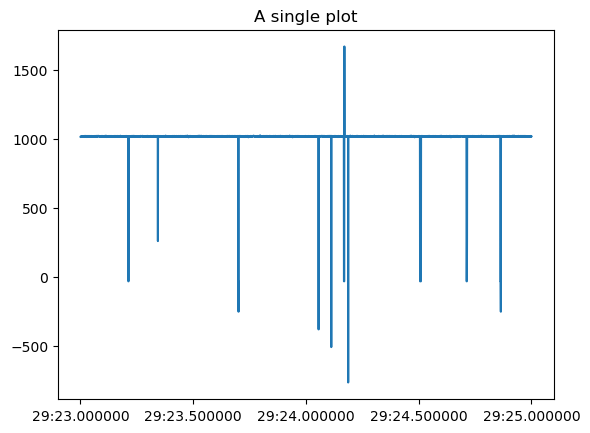

In [13]:
#single plot
plot5= Real_data[(Real_data['time'] > '2022-09-13 18:29:23.000000') & (Real_data['time'] <= '2022-09-13 18:29:25.000000')]
fig, ax = plt.subplots()
ax.plot(plot5['time'],plot5['z'])
ax.set_title('A single plot')

##### In case of real fall, Value of Z is above 1500 and We checked the values for other time duration and second maximum value for z was around 1150. So can we say that when a real fall happens, sensore give values above 1500? 

##### we can check this if we get data f

### Negative Events

In [14]:
# Basedirectory where all the data is stored
BASEDIR = pathlib.Path('/store/projects/fallki/')
LONGTIMEDIR = pathlib.Path('Langzeitmessung/2/')
# one sensor was applied to the floor and was applied to the bed
df = pd.read_parquet(BASEDIR / LONGTIMEDIR / 'standalone.parquet') 
df1 = pd.read_parquet(BASEDIR / LONGTIMEDIR /'bett.parquet') 
df

,t_s,x,y,z,t_h
0,0.000000,19.0,2.0,1024.0,0.000000e+00
1,0.000625,23.0,-1.0,1024.0,1.735191e-07
2,0.001249,18.0,-2.0,1024.0,3.470382e-07
3,0.001874,19.0,-2.0,1026.0,5.205573e-07
4,0.002499,19.0,0.0,1028.0,6.940765e-07
...,...,...,...,...,...
5763178,3600.077547,21.0,-1.0,1026.0,1.000022e+00
5763179,3600.078172,21.0,-3.0,1023.0,1.000022e+00
5763180,3600.078797,19.0,1.0,1022.0,1.000022e+00
5763181,3600.079421,19.0,-1.0,1026.0,1.000022e+00


Remark: the naming and conventions are not consistent with any common python style (e.g. pep8). This is due to the fact that this was created dynamically. 
If you find it helps you, you are free to change your variable, array, function names etc..

Also it would be a good idea to save the training data set after generating it. This is currently not done but it is desirable for reproducibility

In [15]:
Negative_Events_Data = []
Negative_Events = []
Negative_Beschreibungen = 20000 * ["Leer"]

# get 20000 samples and negative training samples and calculate there features.
for i in range(10000):
    Interval_Bett = RandomInterval(df)
    Interval_Boden = RandomInterval(df1)
    Negative_Events_Data.append(Interval_Bett)
    Negative_Events_Data.append(Interval_Boden)
    Features_Bett = CalculateFeatures(Interval_Bett)
    Features_Boden = CalculateFeatures(Interval_Boden)
    Negative_Events.append(np.array(list(Features_Bett.values())))
    Negative_Events.append(np.array(list(Features_Boden.values())))
    
Negative_Labels = len(Negative_Events) * [[0]]

In [16]:
len(Negative_Labels)

20000

In [17]:
%%html
<style>
table {float:left}
</style>

### Positive Events

The following table describes the different measurement settings that were used during the lab measurements:

| run | floor  | storey | distance to sensor [m] | room size |
|:-----|--------|--------|------------------------|-----------|
| L1   | PVC    | EG     | 1                      | large     |
| L2   | carpet | EG     | 1                      | large     |
| L3   | PVC    | OG     | 1                      | small     |
| L4   | carpet | OG     | 1                      | small     |
| L5   | PVC    | EG     | 3                      | large     |
| L6   | carpet | EG     | 3                      | large     |
| L7   | PVC    | OG     | 3                      | small     |
| L8   | carpet | OG     | 3                      | small     |








Three sensors (teensys) were used during every measurement.

In [18]:
# load data
FAKEDIR = pathlib.Path('Fake-Events/2. Fake-Events Messung/')

df_fake = pd.read_parquet(BASEDIR / FAKEDIR / 'gSensoren_FakeEvents.parquet')
df_fake_groups = df_fake.groupby(['teensy', 'experiment', 'run', 'rep'])

In [19]:
df_fake_groups

All different measured fall events are listed below. Every event was measured three times.

In [20]:
pd.DataFrame(df_fake.experiment.drop_duplicates())

,experiment
0,1.5L Flasche
0,Hantel
0,Pflegeartikel
0,Koffer
0,Krücken
0,2 Bücher
0,Schlüsselbund
0,Springen
0,Getränkeflasche
0,Stuhl kippt


We therefore expect a total amount of 1080 measured fall events. (replications (3) * different events (15) * different settings (8) * number of sensors (3))

In [21]:
len(df_fake[['teensy', 'experiment', 'run', 'rep']].drop_duplicates())

1079

One event seems to bei missing, but this is not too bad for now.

Extract the training data and labels:

In [22]:
event_measurements = df_fake[['teensy', 'experiment', 'run', 'rep']].drop_duplicates()

Positive_Events_Data = []
Positive_Events = []
Positive_Beschreibungen = []
a=[]

for _, measurement in event_measurements.iterrows():
    data = df_fake_groups.get_group((measurement['teensy'], measurement['experiment'], measurement['run'], measurement['rep']))
    Positive_Events_Data.append(np.array(data['z']))
    a.append(np.array(data))
    Positive_Beschreibungen.append(np.array(data['experiment'][0]))
    Positive_Events.append(CalculateFeatures(np.array(data['z'])))
    
# Labels for first step:
Positive_Labels = np.array(len(Positive_Events) * [[1]])


In [23]:
dfL1 = df_fake[(df_fake.experiment == 'Dummy') & (df_fake.run == 'L1')]
dfL2 = df_fake[(df_fake.experiment == 'Dummy') & (df_fake.run == 'L2')]
dfL3 = df_fake[(df_fake.experiment == 'Dummy') & (df_fake.run == 'L3')]
dfL4 = df_fake[(df_fake.experiment == 'Dummy') & (df_fake.run == 'L4')]
dfL5 = df_fake[(df_fake.experiment == 'Dummy') & (df_fake.run == 'L5')]
dfL6 = df_fake[(df_fake.experiment == 'Dummy') & (df_fake.run == 'L6')]
dfL7 = df_fake[(df_fake.experiment == 'Dummy') & (df_fake.run == 'L7')]
dfL8 = df_fake[(df_fake.experiment == 'Dummy') & (df_fake.run == 'L8')]

In [24]:
dfL11 = df_fake[df_fake.run == 'L1']
dfL22 = df_fake[df_fake.run == 'L2']
dfL33 = df_fake[df_fake.run == 'L3']
dfL44 = df_fake[df_fake.run == 'L4']
dfL55 = df_fake[df_fake.run == 'L5']
dfL66 = df_fake[df_fake.run == 'L6']
dfL77 = df_fake[df_fake.run == 'L7']
dfL88 = df_fake[df_fake.run == 'L8']

In [25]:
dfL33[dfL33.z < 0]

,teensy,experiment,run,rep,t,x,y,z
4973,3,Pflegeartikel,L3,3,3.107411,182.0,26.0,-376.0
4977,3,Pflegeartikel,L3,3,3.109911,63.0,8.0,-183.0
4979,3,Pflegeartikel,L3,3,3.111160,51.0,-231.0,-24.0
3615,3,2 Bücher,L3,2,2.258150,128.0,-142.0,-1160.0
3617,3,2 Bücher,L3,2,2.259399,-38.0,-334.0,-792.0
...,...,...,...,...,...,...,...,...
4051,2,Hantel,L3,1,2.525259,-70.0,38.0,-85.0
4052,2,Hantel,L3,1,2.525882,7.0,-316.0,-179.0
3667,3,Koffer,L3,2,2.290797,97.0,286.0,-171.0
3692,3,Koffer,L3,2,2.306415,218.0,210.0,-421.0


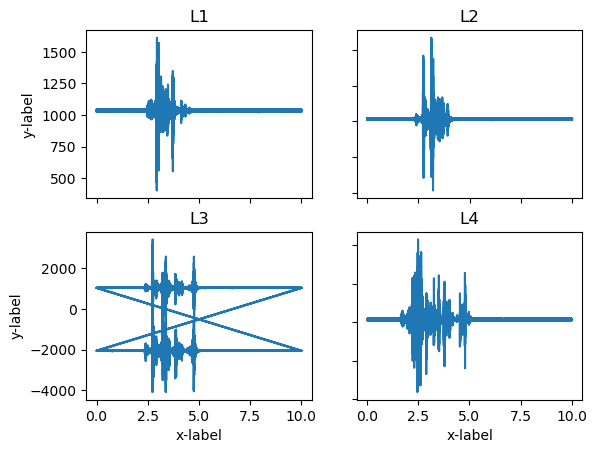

In [26]:
#dummy values for L1 - L4
fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(dfL1['t'],dfL1['z'], 'tab:blue')
axs[0, 0].set_title('L1')
axs[0, 1].plot(dfL2['t'],dfL2['z'], 'tab:blue')
axs[0, 1].set_title('L2')
axs[1, 0].plot(dfL3['t'],dfL3['z'], 'tab:blue')
axs[1, 0].set_title('L3')
axs[1, 1].plot(dfL4['t'],dfL4['z'], 'tab:blue')
axs[1, 1].set_title('L4')

for ax in axs.flat:
    ax.set(xlabel='x-label', ylabel='y-label')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

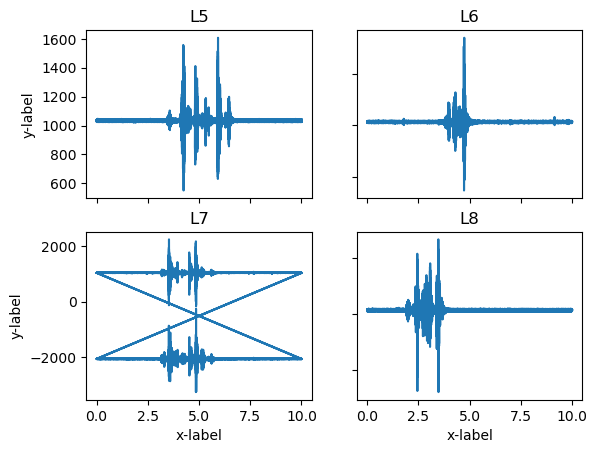

In [27]:
#dummy values for L5 - L8
fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(dfL5['t'],dfL5['z'], 'tab:blue')
axs[0, 0].set_title('L5')
axs[0, 1].plot(dfL6['t'],dfL6['z'], 'tab:blue')
axs[0, 1].set_title('L6')
axs[1, 0].plot(dfL7['t'],dfL7['z'], 'tab:blue')
axs[1, 0].set_title('L7')
axs[1, 1].plot(dfL8['t'],dfL8['z'], 'tab:blue')
axs[1, 1].set_title('L8')

for ax in axs.flat:
    ax.set(xlabel='x-label', ylabel='y-label')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

In [28]:
Positive_Events = pd.DataFrame.from_dict(Positive_Events).to_numpy()

In [29]:
Dummy = np.where(event_measurements['experiment'] == 'Dummy')[0]

# Labels for second step (not relevant for this notbook):
Dummy_Labels = np.zeros(len(event_measurements))
Dummy_Labels[Dummy] = 1 

In [30]:
len(Dummy)

72

### Combine Positve and Negative events to one array

In [31]:
All_Events = np.concatenate((Negative_Events, Positive_Events)) #Features of negative and positive events
All_Beschreibungen = Negative_Beschreibungen + Positive_Beschreibungen # Leer and experiment name

All_Labels = np.concatenate((Negative_Labels, Positive_Labels)) # 0's and 1's
All_Events_Data = Negative_Events_Data + Positive_Events_Data # 'Z' value for postive and negative
All_Dummy_Labels = np.concatenate((Negative_Labels, Dummy_Labels.reshape(1079,1))) # negative(0) and dummy events(1) combined

In [32]:
#Shuffle events:
shuffler = np.random.permutation(len(All_Events))
All_Events = All_Events[shuffler]
All_Labels = All_Labels[shuffler]
All_Beschreibungen = np.array(All_Beschreibungen)[shuffler]
All_Dummmy_Labels = All_Dummy_Labels[shuffler]
All_Events_Data = np.array(All_Events_Data)[shuffler]


/tmp/ipykernel_3548217/884197006.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  All_Events_Data = np.array(All_Events_Data)[shuffler]


In [33]:
# Derive Labels for Fake Events
All_Fake_Labels = np.zeros(All_Dummmy_Labels.shape)
All_Fake_Labels[(All_Dummmy_Labels == 0).reshape(-1) & (All_Labels == 1).reshape(-1)] = 1 #labeled 1 for all experiments except for dummy. 

# 1. Logistische Regression

### Training

In [34]:
x = All_Events
y = All_Labels

In [35]:
x_train, x_test, y_train, y_test = train_test_split(x, y.ravel(), test_size=0.2)
lr = LogisticRegression(solver='lbfgs', max_iter=1000).fit(x_train, y_train)
pd.crosstab(lr.predict(x_test), y_test)

col_0,0,1
row_0,,
0,4012,0
1,0,204


### Small Test

Take a random sample from the data set and if there is an event calculate and plot the short time fourier transform.

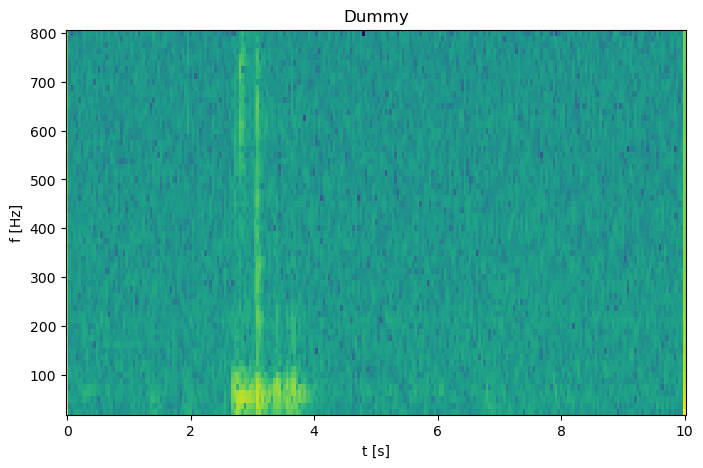

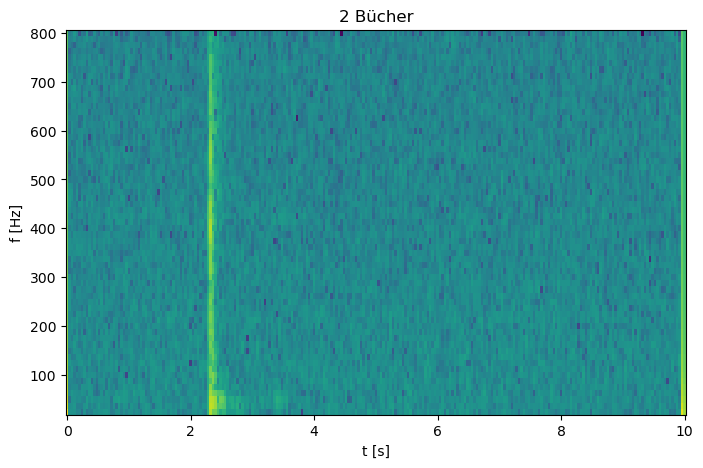

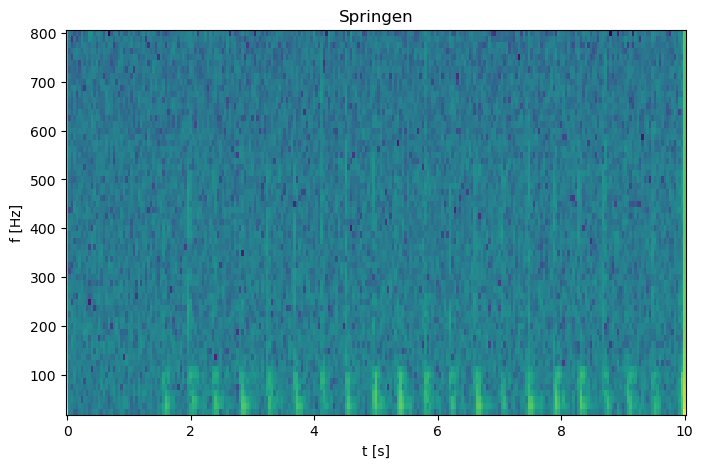

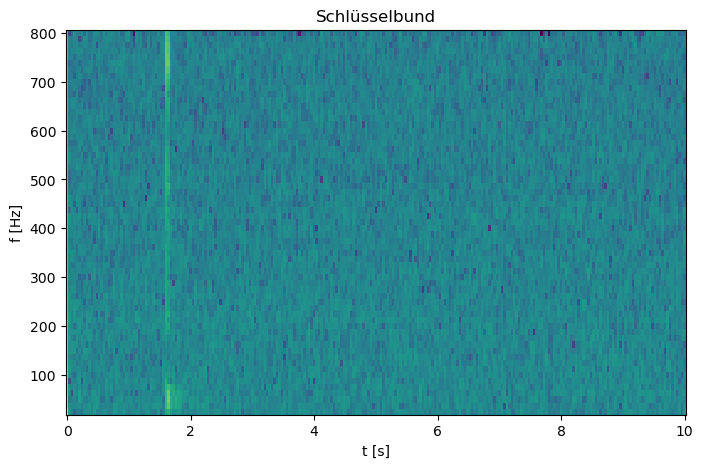

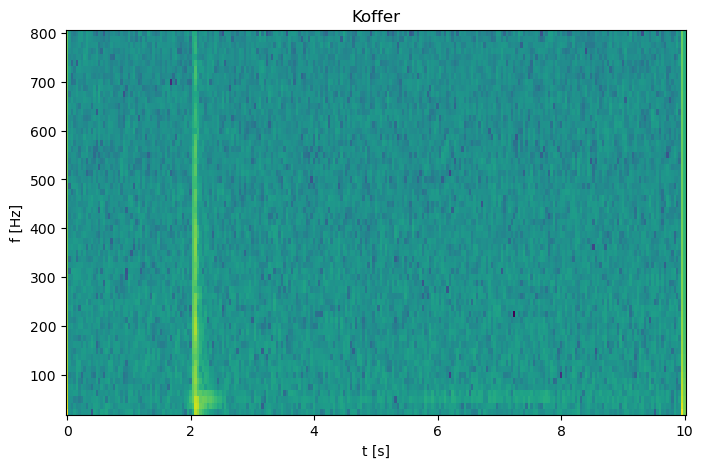

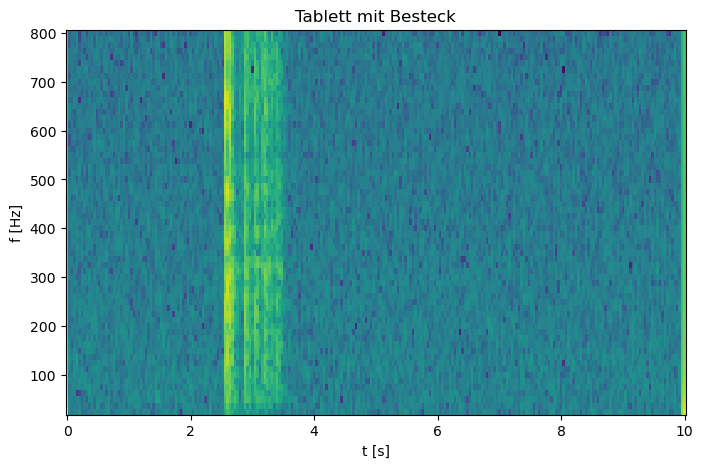

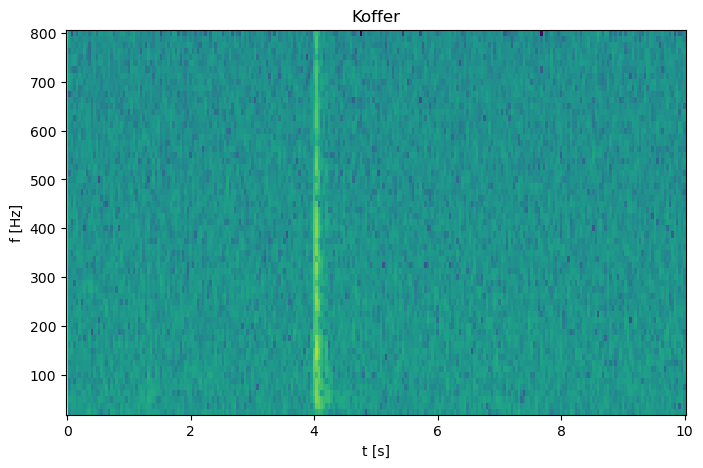

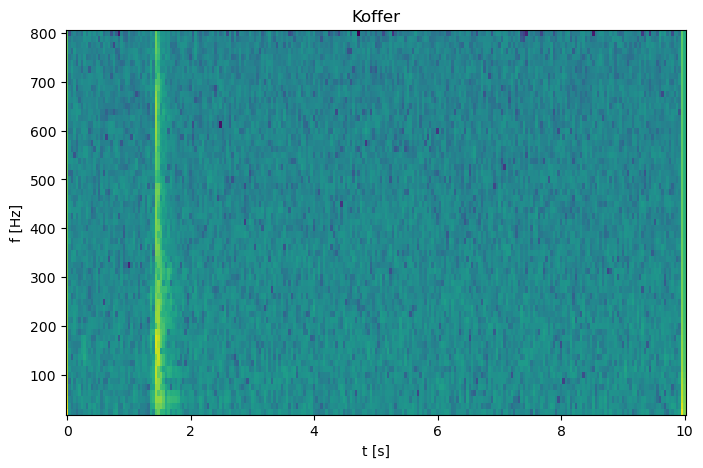

In [36]:
sample = np.random.randint(0, len(All_Events), size=100, dtype=int)

for i, event in enumerate(All_Events_Data[sample]): 
    
    # I should probably restructure the ouput of CalculateFeatures... ^^
    features = np.reshape(np.array(list(CalculateFeatures(event).values())), (1,5))
    detected = lr.predict(features)[0] == 1
    if detected:
            fig, ax = plt.subplots(1, 1, sharex=False, figsize=(8, 5))
            f, t, Zxx = stft(event, 1600, nperseg=128)
            f = f[2:]
            t = t[:251]
            Zxx = Zxx[2:,:251]
            ax.pcolormesh(t, f, np.log(np.abs(Zxx)), shading='nearest')
            ax.set_xlabel("t [s]")
            ax.set_ylabel("f [Hz]")
            ax.set_title(All_Beschreibungen[sample[i]])
            fig.show()
            #print(Zxx.shape)
    else:
        continue